##### Figure S11: Figure 4 presented as deviations from the genome-wide averages.

In [1]:
from collections import defaultdict
import dask.array as da
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd

import allel

import ingenos

In [2]:
base_path = "/overflow/dschridelab/users/rrlove/aedes/"
md_path = f"{base_path}metadata/"
results_path = f"{base_path}results/"
in_base = f"{results_path}popgen/pi_d_saved_values/"
zarr_path = "/proj/dschridelab/rrlove/aedes/vcf/filtered_110122/"

In [3]:
chroms = ["AaegL5_1", "AaegL5_2", "AaegL5_3"]
countries = ["Brazil", "Colombia", "USA", "Kenya", "Senegal", "Gabon"]

##### read in the data and metadata

In [4]:
def return_data(zarr_path, data_type, data_name):
    
    fetch_str = f"{data_type}/{data_name}" 
    
    return da.from_zarr(zarr_path, component=fetch_str)

In [5]:
chroms_dict = defaultdict(dict)

for chrom in ["AaegL5_3"]:
    
    temp_in_path = zarr_path + chrom

    chroms_dict[chrom]["pos"] = return_data(temp_in_path, "variants", "POS")
    chroms_dict[chrom]["chrom"] = return_data(temp_in_path, "variants", "CHROM")
    chroms_dict[chrom]["ref"] = return_data(temp_in_path, "variants", "REF")
    chroms_dict[chrom]["alt"] = return_data(temp_in_path, "variants", "ALT")
    chroms_dict[chrom]["ac"] = return_data(temp_in_path, "variants", "AC")
    chroms_dict[chrom]["qd"] = return_data(temp_in_path, "variants", "QD")
    chroms_dict[chrom]["mq"] = return_data(temp_in_path, "variants", "MQ")
    chroms_dict[chrom]["fs"] = return_data(temp_in_path, "variants", "FS")
    chroms_dict[chrom]["mqrs"] = return_data(temp_in_path, "variants", "MQRankSum")
    chroms_dict[chrom]["rprs"] = return_data(temp_in_path, "variants", "ReadPosRankSum")
    chroms_dict[chrom]["sor"] = return_data(temp_in_path, "variants", "SOR")
    chroms_dict[chrom]["is_snp"] = return_data(temp_in_path, "variants", "is_snp")
    chroms_dict[chrom]["numalt"] = return_data(temp_in_path, "variants", "numalt")
    chroms_dict[chrom]["filter_pass"] = return_data(temp_in_path, "variants", "FILTER_PASS")

    chroms_dict[chrom]["gt"] = return_data(temp_in_path, "calldata", "GT")
    chroms_dict[chrom]["gq"] = return_data(temp_in_path, "calldata", "GQ")
    chroms_dict[chrom]["ad"] = return_data(temp_in_path, "calldata", "AD")
    chroms_dict[chrom]["pl"] = return_data(temp_in_path, "calldata", "PL")
    chroms_dict[chrom]["dp"] = return_data(temp_in_path, "calldata", "DP")
    
    print(chrom, chroms_dict[chrom]["gt"].shape)
    
samples = da.from_zarr(temp_in_path, component="samples")

AaegL5_3 (27660249, 131, 2)


##### read in and filter the metadata

In [6]:
md = pd.read_table(
    md_path + "whole_sample_sorted_country.031522.csv", 
    sep="\t",)

md["locality"] = md["location"].str.split(": ", expand=True)[1]

md.head()

,sample_id,sample_short,location,sex,batch,sample_id_cat,country,locality
0,FEMALE_1-F1_CGCATGAT-TCAGGCTT_S1,FEMALE_1,Colombia: Rio Claro,F,1,FEMALE_1-F1_CGCATGAT-TCAGGCTT_S1,Colombia,Rio Claro
1,FEMALE_10-F10_GTGCCATA-ACTAGGAG_S2,FEMALE_10,Colombia: Rio Claro,F,1,FEMALE_10-F10_GTGCCATA-ACTAGGAG_S2,Colombia,Rio Claro
2,FEMALE_11-F11_CGTTGCAA-CGCTCTAT_S3,FEMALE_11,Colombia: Rio Claro,F,1,FEMALE_11-F11_CGTTGCAA-CGCTCTAT_S3,Colombia,Rio Claro
3,FEMALE_12-F12_TGAAGACG-TGGCATGT_S4,FEMALE_12,Colombia: Rio Claro,F,1,FEMALE_12-F12_TGAAGACG-TGGCATGT_S4,Colombia,Rio Claro
4,FEMALE_14-F14_ACGTTCAG-GCACAACT_S6,FEMALE_14,Colombia: Rio Claro,F,1,FEMALE_14-F14_ACGTTCAG-GCACAACT_S6,Colombia,Rio Claro


##### drop closely-related specimens

In [7]:
to_drop = np.loadtxt(md_path + "close_kin_removed_new_dataset.txt", 
                     dtype="str")

to_drop

array(['SRR11006849', 'SRR11006846', 'SRR6768018', 'FEMALE_17',
       'FEMALE_22', 'SRR11006674', 'SRR11006683', 'SRR11006754'],
      dtype='<U11')

In [8]:
to_drop_bool = (~(md["sample_short"].isin(to_drop)).values)

np.sum(to_drop_bool)

123

In [9]:
md_filtered = md.loc[to_drop_bool]

md_filtered.shape

(123, 8)

##### read in genes

In [10]:
gff3 = pd.read_table("/overflow/dschridelab/users/rrlove/aedes/refs/aegy/VectorBase-54_AaegyptiLVP_AGWG.gff",
                     sep="\t", comment="#", header=None)

gff3.columns = ["seqid", "source", "type", "start", "end", "score", "strand",
               "phase", "attributes"]

gff3["name"] = gff3["attributes"].str.split(";", expand=True)[0].str.lstrip("ID=")

genes = gff3.loc[gff3["type"] == "protein_coding_gene"]

genes.head()

,seqid,source,type,start,end,score,strand,phase,attributes,name
0,AaegL5_3,VEuPathDB,protein_coding_gene,157422094,157471671,.,-,.,ID=AAEL010223;description=phosphatidylserine d...,AAEL010223
67,AaegL5_2,VEuPathDB,protein_coding_gene,65150768,65155203,.,-,.,ID=AAEL013940;description=chromatin assembly f...,AAEL013940
79,AaegL5_2,VEuPathDB,protein_coding_gene,303181186,303183527,.,+,.,ID=AAEL002384;description=unspecified product,AAEL002384
89,AaegL5_1,VEuPathDB,protein_coding_gene,247947181,247966533,.,-,.,ID=AAEL003769;description=Methionine aminopept...,AAEL003769
105,AaegL5_3,VEuPathDB,protein_coding_gene,368609784,368611605,.,+,.,ID=AAEL014609;Name=CYP9J26;description=cytochr...,AAEL014609


In [11]:
genes_1 = genes.loc[genes["seqid"] == "AaegL5_1"]
genes_2 = genes.loc[genes["seqid"] == "AaegL5_2"]
genes_3 = genes.loc[genes["seqid"] == "AaegL5_3"]

##### filter by country

In [12]:
country_bools = {}

for country in countries:
    
    country_bools[country] = (md_filtered["country"] == country).values
    
country_bools.keys()

dict_keys(['Brazil', 'Colombia', 'USA', 'Kenya', 'Senegal', 'Gabon'])

In [13]:
region_flt = ((chroms_dict[chrom]["pos"] > 310000000) & \
            (chroms_dict[chrom]["pos"] < 320000000))

np.sum(region_flt).compute()

641298

In [14]:
vgsc_flt = ((chroms_dict[chrom]["pos"] > 315926360) &\
            (chroms_dict[chrom]["pos"] < 316405639))

np.sum(vgsc_flt.compute())

33298

In [15]:
vgsc_gt = allel.GenotypeArray(chroms_dict[chrom]["gt"]).subset(sel0 = region_flt, 
                                                          sel1 = to_drop_bool)

vgsc_gt.shape

(641298, 123, 2)

In [16]:
pos = chroms_dict[chrom]["pos"][region_flt].compute()

pos.shape

(641298,)

##### calculate pi and Tajima's D within Vgsc

In [17]:
vgsc_overlapping_by_country = defaultdict(dict)

for country, country_flt in country_bools.items():

    country_gt = vgsc_gt.subset(sel1 = country_flt)
    
    pi, windows, n_bases, counts = allel.windowed_diversity(pos, 
                                                            country_gt.count_alleles(), 
                                                            size=500000, 
                                                            step=50000)

    vgsc_overlapping_by_country["pi"][country] = \
    (pi, windows, n_bases, counts)

    d, windows, counts = allel.windowed_tajima_d(pos, 
                                                 country_gt.count_alleles(), 
                                                 size=500000,
                                                 step=50000)

    vgsc_overlapping_by_country["d"][country] = \
    (d, windows, counts)
    
    print(country)

Brazil
Colombia
USA
Kenya
Senegal
Gabon


In [18]:
#from https://stackoverflow.com/questions/27575257/how-to-divide-y-ticks-by-a-certain-number-in-matplotlib

def numfmt(x, pos):
    s = '{}'.format((x / 1000000))
    return s

yfmt = tkr.FuncFormatter(numfmt)

##### read in previously-calculated genome-wide values

In [19]:
pi_dict = defaultdict(dict)
d_dict = defaultdict(dict)

for chrom in ["AaegL5_1", "AaegL5_2", "AaegL5_3"]:
    
    for country in countries:
        
        pi_in_base = f"{in_base}{chrom}_{country}_pi"
        d_in_base = f"{in_base}_{chrom}_{country}_d"
                
        with open(f"{pi_in_base}_values.020123.txt", "r") as in_file:
            values = json.load(in_file)
                    
        with open(f"{pi_in_base}_windows.020123.txt", "r") as in_file:
            windows = json.load(in_file)

        with open(f"{pi_in_base}_counts.020123.txt", "r") as in_file:
            counts = json.load(in_file)
            
        pi_dict[chrom][country] = (np.array(values), 
                                        np.array(windows), 
                                        np.array(counts))
        
        with open(f"{d_in_base}_values.020123.txt", "r") as in_file:
            values = json.load(in_file)
                    
        with open(f"{d_in_base}_windows.020123.txt", "r") as in_file:
            windows = json.load(in_file)

        with open(f"{d_in_base}_counts.020123.txt", "r") as in_file:
            counts = json.load(in_file)
            
        d_dict[chrom][country] = (np.array(values), 
                                       np.array(windows), 
                                       np.array(counts))
        
        print(chrom, country)

AaegL5_1 Brazil
AaegL5_1 Colombia
AaegL5_1 USA
AaegL5_1 Kenya
AaegL5_1 Senegal
AaegL5_1 Gabon
AaegL5_2 Brazil
AaegL5_2 Colombia
AaegL5_2 USA
AaegL5_2 Kenya
AaegL5_2 Senegal
AaegL5_2 Gabon
AaegL5_3 Brazil
AaegL5_3 Colombia
AaegL5_3 USA
AaegL5_3 Kenya
AaegL5_3 Senegal
AaegL5_3 Gabon


##### calculate mean, median, and standard deviation for each statistic and country

In [20]:
genome_stats_new = defaultdict(lambda: defaultdict(dict))

for country in countries:
    
    pi_list = []
    
    d_list = []
    
    for chrom in chroms:
    
        pi, _, _ = pi_dict[chrom][country]

        d, _, _ = d_dict[chrom][country]

        pi_list.append(pi)
        
        d_list.append(d)
        
    all_pi = np.concatenate(pi_list)
    
    all_d = np.concatenate(d_list)
    
    print(country)
    
    genome_stats_new[country]["pi"]["mean"] = np.mean(all_pi)
    genome_stats_new[country]["pi"]["median"] = np.median(all_pi)
    genome_stats_new[country]["pi"]["std"] = np.std(all_pi)
    
    genome_stats_new[country]["d"]["mean"] = np.mean(all_d)
    genome_stats_new[country]["d"]["median"] = np.median(all_d)
    genome_stats_new[country]["d"]["std"] = np.std(all_d)

    print(f"mean pi in {country}: {np.mean(all_pi)}")
    print(f"median pi in {country}: {np.median(all_pi)}")
    print(f"standard deviation of pi in {country}: {np.std(all_pi)}", "\n")
    
    print(f"mean D in {country}: {np.mean(all_d)}")
    print(f"median D in {country}: {np.median(all_d)}")
    print(f"standard deviation of D in {country}: {np.std(all_d)}", "\n")

Brazil
mean pi in Brazil: 0.005390448270066387
median pi in Brazil: 0.005278018951930091
standard deviation of pi in Brazil: 0.001521450941262946 

mean D in Brazil: 0.8031531003570727
median D in Brazil: 0.8407943390729465
standard deviation of D in Brazil: 0.4803460641796529 

Colombia
mean pi in Colombia: 0.005367805911105543
median pi in Colombia: 0.005262005378108322
standard deviation of pi in Colombia: 0.0015174470859988943 

mean D in Colombia: 0.406856790322233
median D in Colombia: 0.4588261059579707
standard deviation of D in Colombia: 0.4660414072522905 

USA
mean pi in USA: 0.0066522985161808395
median pi in USA: 0.006418255961674087
standard deviation of pi in USA: 0.0018446026228528063 

mean D in USA: 0.4628093753927301
median D in USA: 0.4991688751118426
standard deviation of D in USA: 0.43759687175144446 

Kenya
mean pi in Kenya: 0.00968188780299935
median pi in Kenya: 0.009867178193654137
standard deviation of pi in Kenya: 0.0020068585808015677 

mean D in Kenya: -0.

In [21]:
outString = ingenos.make_date_stamp(
    results_path + "Vssc/Vgsc_pi_D_z_scores", ".pdf")

outString

'/overflow/dschridelab/users/rrlove/aedes/results/Vssc/Vgsc_pi_D_z_scores.021123.pdf'

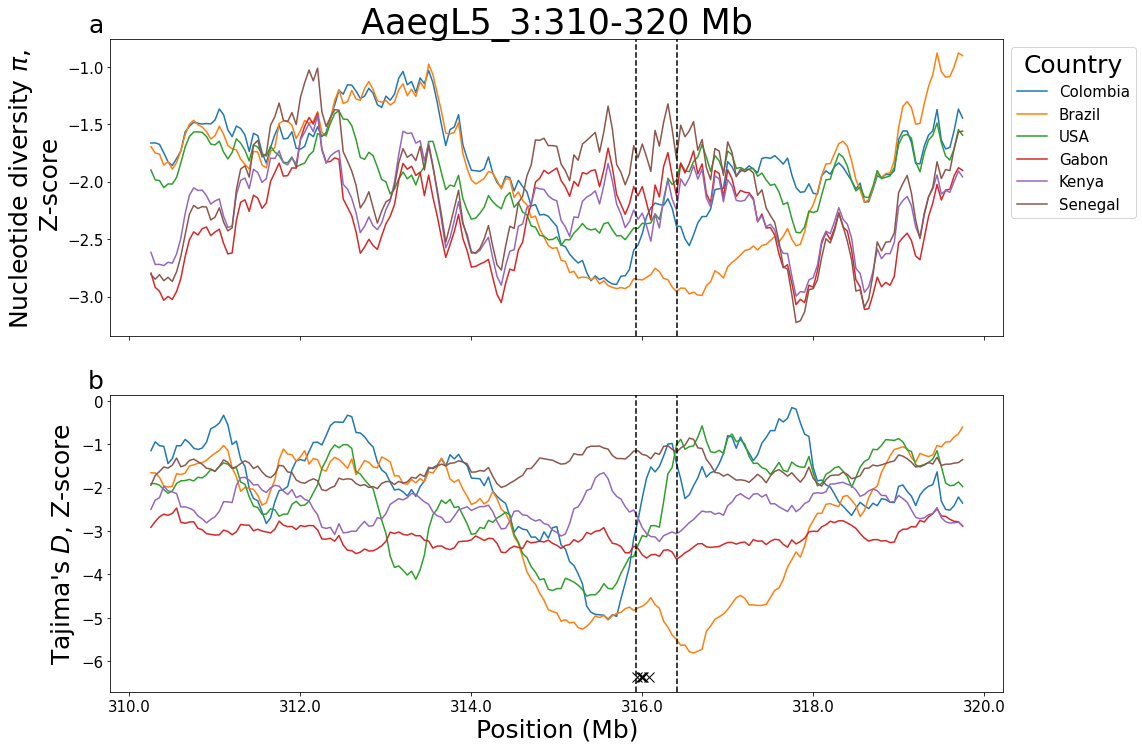

In [22]:
fig, axes = plt.subplots(nrows=2, figsize=(16, 12), sharex="col")

for country in ["Colombia", "Brazil", "USA", "Gabon", "Kenya", "Senegal"]:

    pi, pi_windows, n_bases, pi_counts = \
    vgsc_overlapping_by_country["pi"][country]

    d, d_windows, d_counts = \
    vgsc_overlapping_by_country["d"][country]
    
    mean_pi = genome_stats_new[country]["pi"]["mean"]
    std_pi = genome_stats_new[country]["pi"]["std"]
    
    mean_d = genome_stats_new[country]["d"]["mean"]
    std_d = genome_stats_new[country]["d"]["std"]
    
    axes[0].plot(np.mean(pi_windows, axis=1), (pi - mean_pi) / std_pi, 
                 label=country)

    axes[1].plot(np.mean(d_windows, axis=1), (d - mean_d) / std_d, 
                 label=country)

trans = transforms.blended_transform_factory(
    axes[1].transData, axes[1].transAxes)

for snp in [315939224, 315983763, 315999297, 316014588, 316080722]:

    axes[1].plot(snp, 0.05, marker="x", markersize=10, color="black", 
                 transform=trans, linestyle=" ")

lower_bound = axes[1].get_ylim()[0]
axes[1].set_ylim(bottom=lower_bound*1.1)

for ax in axes:
    ax.axvline(x = 315926360, linestyle = "--", color = "black")
    ax.axvline(x = 316405639, linestyle = "--", color = "black")

axes[0].set_title("AaegL5_3:310-320 Mb", fontsize=35)
axes[0].legend(title="Country", fontsize=15, title_fontsize=25,
                   bbox_to_anchor=(1.0, 1))
axes[0].set_ylabel(r"Nucleotide diversity $\pi$," + "\n Z-score", fontsize=25)

axes[1].set_xlabel("Position (Mb)", size=25)
axes[1].xaxis.set_major_formatter(yfmt)
axes[1].set_ylabel(r"Tajima's $D$, Z-score", fontsize=25)

for ax in axes:
    ax.tick_params(axis="both", labelsize=15)

for i, ax in enumerate(axes):
    label = ["a","b"][i]
    ax.text(x=-0.025, y=1.025, s=label, 
            transform=ax.transAxes, fontsize=25)
    
#plt.tight_layout()
    
#plt.savefig(outString, bbox_inches="tight")